# Fourth Down Project

Author: Seth Billiau, Sarah Lucioni

In [438]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [180]:
# Load Data
DATADIR = 'data/'
nfl_pbp = pd.read_csv(DATADIR + 'NFL_PbP_2009_2018_4thDownAnalysis.csv')



# Fourth Down Model

## Global Variables

In [372]:
# 4th and ... (+ 1)
max_fourth_ytg = 21

# Yardline (+ 1)
max_yardline = 100

### Calculate expected value of points after touchdown - PAT vs. 2-point conversion
extra_point_plays = sum(nfl_pbp.extra_point_attempt == 1)
two_point_plays = sum(nfl_pbp.two_point_attempt == 1)
plays_after_TD = extra_point_plays + two_point_plays

# Get Prob of kicking a PAT and prob of success
p_extra_point = extra_point_plays / plays_after_TD
p_extra_point_success = np.mean(nfl_pbp[nfl_pbp.extra_point_attempt == 1].extra_point_result == 'good')

# Get Prob of 2 pt conversion and prob of success
p_two_point = two_point_plays / plays_after_TD
p_two_point_success = np.mean(nfl_pbp[nfl_pbp.two_point_attempt == 1].two_point_conv_result == 'success')

# EV points after TD
expected_points_after = p_extra_point * p_extra_point_success + 2 * p_two_point * p_two_point_success
expected_points_after

## Expected Value of Going for it

In [374]:
def prob_of_first_down(by_qtr_flag=False, qtr=None):
    """
    Calculates dictionary of probabilities of getting a first down given yds to go
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    dict: Keys are yards to go, values are probs. of first down given yards to go
    """
    
    passRunPlays = nfl_pbp[(nfl_pbp.play_type == "pass") | 
                           (nfl_pbp.play_type == 'run')]
    
    if by_qtr_flag:
        passRunPlays = passRunPlays[passRunPlays.qtr == qtr]
    else: 
        passRunPlays = passRunPlays[(passRunPlays.game_seconds_remaining >= 60) & (abs(passRunPlays.total_home_score - passRunPlays.total_away_score) > 8)]
    
    
    
    # Get average probability of getting a first down 
    probFirstDown = {}
    for x in range(1, max_fourth_ytg):
        probFirstDown[x] = np.mean(passRunPlays.yards_gained[passRunPlays.ydstogo == x ] >= x)
        
    # smooth using cubic polynomial
    smoothedValues = poly_smooth_with_nan(np.arange(1,21,1),np.fromiter(probFirstDown.values(), dtype="float").copy(),deg=3)[0]
    probFirstDown = dict(zip(range(1,21),smoothedValues))
    
    return probFirstDown


In [375]:
def expected_points_on_first(by_qtr_flag=False, qtr=None):
    """
    Calculates expected points for a first down given yardline 
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    dict: Keys are yards to go, values are expected value of first down given yardline
    """
    
    firstDownPlays = nfl_pbp[nfl_pbp.down == 1]
    
    if by_qtr_flag:
        firstDownPlays = firstDownPlays[firstDownPlays.qtr == qtr]
    else: 
        firstDownPlays = firstDownPlays[(firstDownPlays.game_seconds_remaining >= 60) & (abs(firstDownPlays.total_home_score - firstDownPlays.total_away_score) > 8)]
    
        
    expectedPointsOnFirst = {}
    for x in range(1, max_yardline): 
        expectedPointsOnFirst[x] = np.mean(firstDownPlays[firstDownPlays.yardline_100 == x].next_score_relative_to_posteam)   
    
    return expectedPointsOnFirst


In [376]:
def cost_of_turnover(expectedPointsOnFirst):
    """
    Calculates cost of a turnover given yardline 

    Returns:
    costOfTurnover (dict): Keys are yards to go, values are expected cost of turnover given yardline
    """
        
    costOfTurnover = {}
    for x in range(1, max_yardline): 
         costOfTurnover[x] = -1 * expectedPointsOnFirst[max_yardline - x]
            
    return costOfTurnover

In [377]:
def expected_value_go_for_it(by_qtr_flag=False, qtr=None):
    """
    Calculates expected points of going for it for given yds to go and yardline
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    dict of dicts: Outer dict Keys are yardlines, Inner dict keys are yards to go, 
                                          values are expected points of going for it. 
    """
    
    # Initialize all of the necessary components based on quarter before calculating the expected value
    probFirstDown = prob_of_first_down(by_qtr_flag, qtr)
    expectedPointsOnFirst = expected_points_on_first(by_qtr_flag, qtr)
    costOfTurnover = cost_of_turnover(expectedPointsOnFirst)
    
    expectedValueGoForIt = {}
    
    for yardline in range(1, max_yardline):
        outcome_per_yardline = {}
        for yardstogo in range(1, max_fourth_ytg): 
            if (yardline - yardstogo) == 0:
                # If they score on 4th and goal 
                # add 6 points (+6), adjust for points after score, subtract EV giving ball to other team after kickoff (0.8)
                fourth_and_goal_expected_points = 6 + expected_points_after - 0.8
                outcome_per_yardline[yardstogo] = probFirstDown[yardstogo] * fourth_and_goal_expected_points + (1 - probFirstDown[yardstogo]) * costOfTurnover[yardline]
            # Ignore impossible scenarios
            elif (yardline - yardstogo) < 0:
                pass
            else: 
                outcome_per_yardline[yardstogo] = probFirstDown[yardstogo] * expectedPointsOnFirst[yardline - yardstogo] + (1- probFirstDown[yardstogo]) * costOfTurnover[yardline]
        
        expectedValueGoForIt[yardline] = outcome_per_yardline
    
    return expectedValueGoForIt


## Expected Value of Punt

In [378]:
def expected_value_punt(by_qtr_flag=False, qtr=None):
    """
    Calculates expected points of punting given yardline
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    dict: Keys are yardlines, values are expected points of punting 
    """
        
    expectedPointsOnFirst = expected_points_on_first(by_qtr_flag, qtr)
    
    puntPlays = nfl_pbp[nfl_pbp.play_type == "punt"]
    
    if by_qtr_flag:
        puntPlays = puntPlays[puntPlays.qtr == qtr]
    else: 
        puntPlays = puntPlays[(puntPlays.game_seconds_remaining >= 60) & (abs(puntPlays.total_home_score - puntPlays.total_away_score) > 8)]
   
        
        
    expectedValuePunt = {}
    touchback_max = 80
    touchback_EV = -1 * expectedPointsOnFirst[touchback_max]
    for x in range(1, max_yardline): 
        net_punt_distance = np.round(np.mean(puntPlays[puntPlays.yardline_100 == x].kick_distance))
        if math.isnan(net_punt_distance):
            # If there's inadequate data, it's likely because you'd never punt. But if you would punt, it would 
            # be a touchback so for consistency, we'll just add the touchback expected value
            expectedValuePunt[x] = touchback_EV
        else: 
            expectedValuePunt[x] = -1 * expectedPointsOnFirst[min(max_yardline -  x + net_punt_distance, touchback_max)]

    return expectedValuePunt



## Expected Value of FG

In [379]:
# Expected Score for FG 

# FG is 3 points, minus the value of giving the ball back to the opponent at the 75 (-0.8)
expectedValueOfFG = 3 - 0.8

In [380]:
def FG_success_prob(by_qtr_flag=False, qtr=None):
    """
    Calculates probability of a made FG given yardline
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    dict: Keys are yardlines, values are probabilities of making a FG
    """
        
    # find field goal attempts
    field_goal_attempts = nfl_pbp[nfl_pbp['field_goal_attempt']==1]
    
    if by_qtr_flag:
        field_goal_attempts = field_goal_attempts[field_goal_attempts.qtr == qtr]
    else: 
        field_goal_attempts = field_goal_attempts[(field_goal_attempts.game_seconds_remaining >= 60) & (abs(field_goal_attempts.total_home_score - field_goal_attempts.total_away_score) > 8)]
   
        
    # initialize arrays
    field_goal_success_rate = np.zeros(99)
    field_goal_number_attempts = np.zeros(99)
    field_position = np.arange(1, max_yardline) # i.e. from 1-99 yards
    for i in field_position: # i.e. from 1-99 yards
        relevant_rows = field_goal_attempts.yardline_100==i
        field_goal_number_attempts[i-1] = np.sum(relevant_rows)
        if field_goal_number_attempts[i-1]>0:
            field_goal_success_rate[i-1] = np.sum( field_goal_attempts[relevant_rows].posteam_score_post > field_goal_attempts[relevant_rows].posteam_score) / np.sum(relevant_rows)
        else:
            field_goal_success_rate[i-1] = np.nan # no data at this distance

    # # non-parmetric filter
    # field_goal_success_rate_smooth_noparam = non_parametric_smooth_with_nan(field_goal_success_rate.copy(),window=21)

    # make piecewise polynomial fit
    field_goal_success_rate_smooth_poly = np.zeros(99)
    cut_distance = 49 # anything greater than this is set to zero
    field_goal_success_rate_smooth_poly[field_position<=cut_distance] = poly_smooth_with_nan(field_position[field_position<=cut_distance],field_goal_success_rate[field_position<=cut_distance],deg=3)[0]
    
    return dict(zip(range(1,99), np.clip(field_goal_success_rate_smooth_poly, a_min = 0, a_max = 1)))

In [381]:
def expected_value_FG(by_qtr_flag=False, qtr=None):
    """
    Calculates expected points of attempting a FG given yardline
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    dict: Keys are yardlines, values are expected points of attempting a FG
    """
    
    FGSuccessRate = FG_success_prob(by_qtr_flag, qtr)
    expectedPointsOnFirst = expected_points_on_first(by_qtr_flag, qtr)
    
    expectedPointsForFG = {}
    
    for x in range(1, max_yardline):
        if max_yardline - (x + 8) > 0: 
            expectedPointsForFG[x] = FGSuccessRate[x] * expectedValueOfFG - (1- FGSuccessRate[x]) * expectedPointsOnFirst[min(80, max_yardline - (x + 8))]
    
    return expectedPointsForFG 

## Visualization

In [555]:
# 100 for yardline 
# 20 for yards to go

def get_choices(by_qtr_flag=False, qtr=None):
    """
    Calculates optimal choice given yardline and yards to go
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    array, array: Array of optimal choices, array of optimal expected points 
    """
    
    # Initialize all of the necessary expected value data structures
    expectedPointsForFG = expected_value_FG(by_qtr_flag, qtr)
    expectedValuePunt = expected_value_punt(by_qtr_flag, qtr)
    expectedValueGoForIt = expected_value_go_for_it(by_qtr_flag, qtr)
    

    # Create dictionaries and an array to keep track of the max expected value and the choices
    expectedPointsArray = {}
    choiceArray = {}
    choiceArrayNP = np.zeros((max_fourth_ytg, max_yardline))
    expectedPointsArrayNP = np.zeros((max_fourth_ytg, max_yardline))

    choiceList = ["FG", "Punt", "Go For It"]
    for yardline in range(1, max_yardline):
        
        # Get FG expected value given yardline 
        if yardline > 91: 
            # Set this to some incredibly high value so that it'll never be chosen
            # since kicking a FG from 90+ yards out is a terrible idea 
            FGexpected = -100 
        else:
            FGexpected = expectedPointsForFG[yardline]
            
        # Get punt expected value given yardline    
        puntExpected = expectedValuePunt[yardline]


        for yardstogo in range(1, min(yardline, max_fourth_ytg - 1) + 1):
            
            # Initialize dicts if first iteration
            if yardstogo == 1: 
                choiceArray[yardline] = {}
                expectedPointsArray[yardline] = {}
            
            # Get Expected value of going for it given yardline and yards to go 
            GoForItExpected = expectedValueGoForIt[yardline][yardstogo]
            
            # Get choice ID and add choice to choiceArray
            choiceID = np.array([FGexpected, puntExpected, GoForItExpected]).argmax()
            choiceArray[yardline][yardstogo] = choiceList[choiceID]
            
            # Set the choice in choiceArrayNP to the ID + 1 so that 0 indicates impossible positions
            choiceArrayNP[yardstogo][yardline] = choiceID + 1
                
            # Add correct expected points to expectedPointsArray
            expectedPointsArray[yardline][yardstogo] = max([FGexpected, puntExpected, GoForItExpected])
            expectedPointsArrayNP[yardstogo][yardline] = max([FGexpected, puntExpected, GoForItExpected])

    return choiceArrayNP, expectedPointsArrayNP


In [631]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import BoundaryNorm

def visualize_model(title, by_qtr_flag=False, qtr=None):
    """
    Visualizes optimal choices given yardline and yards to go
    
    Parameters:
    by_qtr_flag (bool): Limits dataset to plays in qtr 
    qtr (int): quarter in which a play occured 
  
    Returns:
    None: Side effect creates a plot.
    """
    choiceArrayNP, _ = get_choices(by_qtr_flag, qtr)

    # Create an array mask so that we don't plot the 0 values
    choice_mask = np.ma.masked_values(choiceArrayNP, 0)
    
    plt.figure(figsize=(20, 4))

    cmap = plt.cm.Dark2  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
#     cmaplist[0] = (.5, .5, .5, 1.0)

    # create the new map
    cmap = LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(1, 4, 4)
    norm = BoundaryNorm(bounds, cmap.N)
    
    with sns.axes_style("white"):
        ax = sns.heatmap(choiceArrayNP, mask=choice_mask.mask, vmin=0, vmax=3, xticklabels=5, yticklabels=5, 
                         cmap=cmap, cbar=False, linewidths=.1, norm = norm)
        ax.set(xlim=(1, max_yardline), ylim=(max_fourth_ytg, 1))
#     colorbar = ax.collections[0].colorbar
#     colorbar.set_ticks([1.5, 2.5, 3.5])
#     colorbar.set_ticklabels(['Field Goal', 'Punt',  'Go For It'])


    # Manually specify colorbar labelling after it's been generated
    plt.title(title, fontsize=30)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("4th and ...", fontsize=18)
    plt.xlabel("Distance to Goal Line", fontsize=18)
    plt.show()

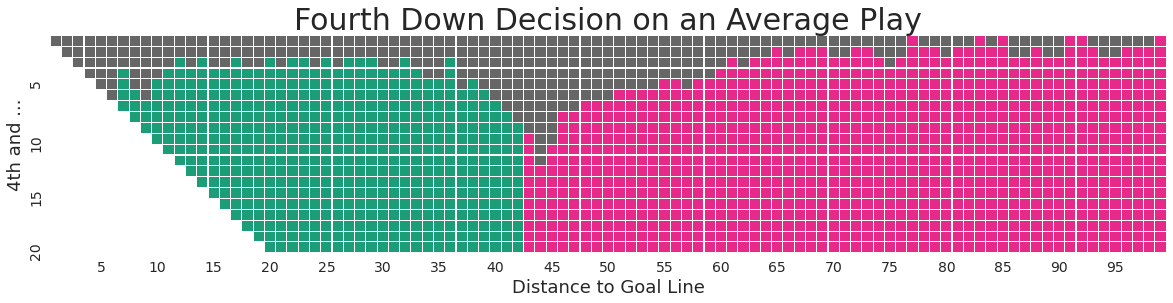

In [632]:
# Fourth Down Model for an average time/play in a game 
# (NOT for a few seconds before the end of game or when you are losing terribly)
visualize_model("Fourth Down Decision on an Average Play")

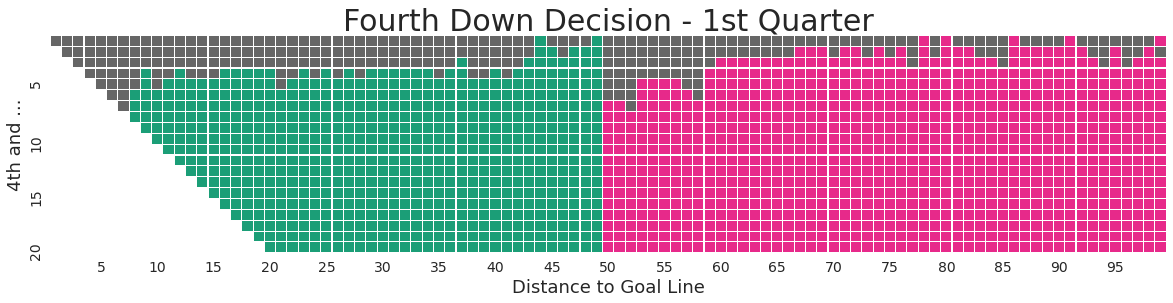

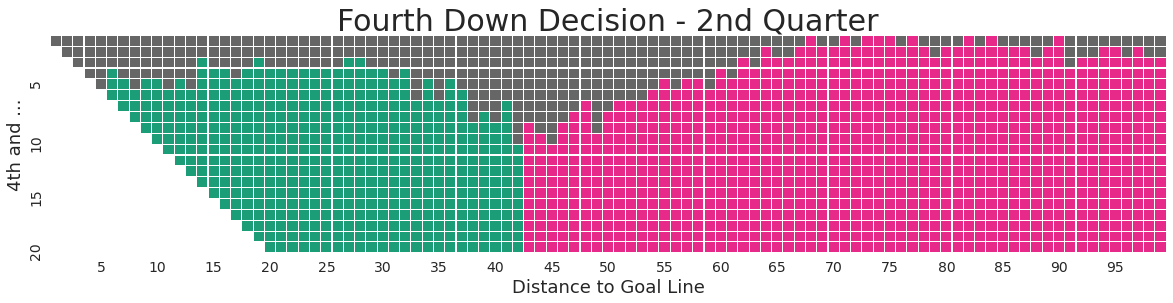

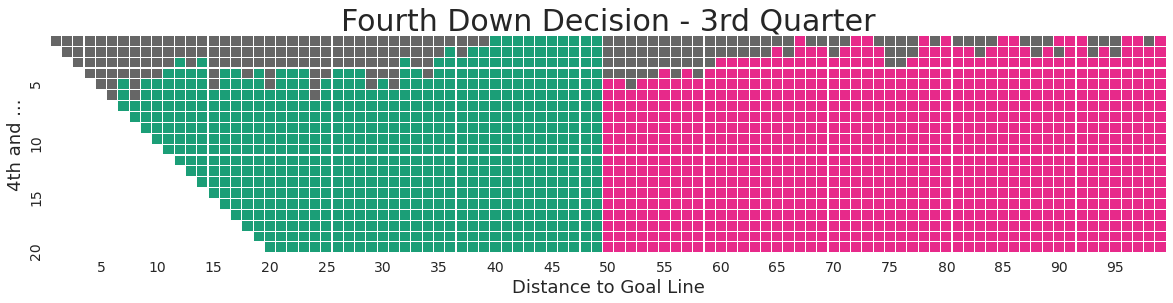

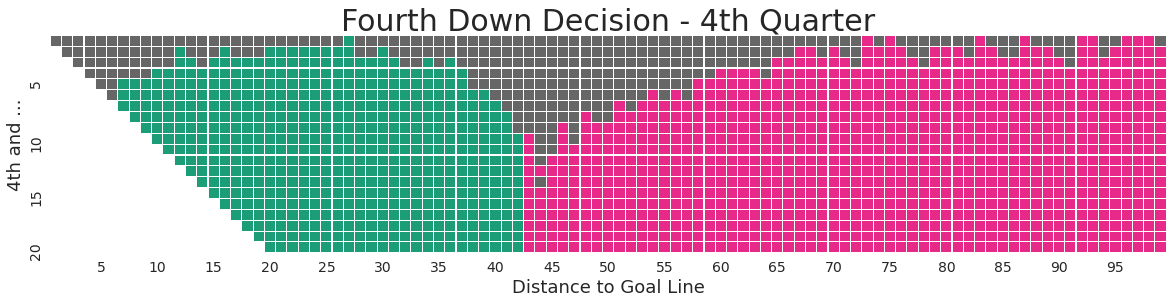

In [638]:
# Fourth Down Model for an average time/play in the second quarter 
visualize_model("Fourth Down Decision - 1st Quarter", True, 1)
visualize_model("Fourth Down Decision - 2nd Quarter", True, 2)
visualize_model("Fourth Down Decision - 3rd Quarter", True, 3)
visualize_model("Fourth Down Decision - 4th Quarter", True, 4)